i=60, files_missing=36801


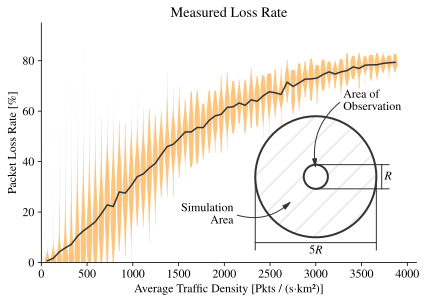

In [2]:
import sys, os
import json
import pandas as pd
import numpy as np
import time, math
import cv2
from operator import sub
import matplotlib
import matplotlib.transforms as transforms
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams.update({
    'font.family': 'serif',
    "font.serif": 'Times',
    'font.size': 12,
    'text.usetex': True,
    'pgf.rcfonts': False,
    'figure.dpi': 300,
    'savefig.dpi': 300
})

def get_aspect(ax):
    # Total figure size
    figW, figH = ax.get_figure().get_size_inches()
    # Axis size on figure
    _, _, w, h = ax.get_position().bounds
    # Ratio of display units
    disp_ratio = (figH * h) / (figW * w)
    # Ratio of data units
    # Negative over negative because of the order of subtraction
    data_ratio = sub(*ax.get_ylim()) / sub(*ax.get_xlim())

    return disp_ratio / data_ratio


def get_result(v, num_nodes, run, interval = 1000):
    with open(f'../res/v{v}_parsed/summary_collision_n{num_nodes}_i{interval}_r{run}.json') as f:
        data = json.load(f)
        return data

def plot_collsion_rate(i, n_runs=200):
    v = 21
    A = (0.509 * 2.5)**2 * math.pi
    nn = range(20, 1200, 20)
    files_missing = 0

    color='#ffb55a'

    collision_rates = []
    for n in nn:
        c = []
        for r in range(0, n_runs):
            try:
                data = get_result(v, n, r, i)
                cr = data['collision_rate']
                if cr > -1:
                    c.append((cr) * 100)
            except:
                files_missing += 1

        collision_rates.append(np.array(c))
        #collision_rates.append(np.percentile(c, 90))
    # plt.plot(np.array(nn) * 1000/ (i * A), np.array(collision_rates) * 100, label=f'i={i}')
    collision_rates_m = np.array([np.mean(xi) for xi in collision_rates])
    
    factor = 1000 / (i * A)
    positions = np.array(nn) * factor

    fig, ax = plt.subplots()
    fig.tight_layout()

    violin_parts = ax.violinplot(collision_rates, positions, widths=18 * factor, showmeans=False, showmedians=False, showextrema=False, bw_method=0.5)


    for pc in violin_parts['bodies']:
        pc.set_facecolor(color)
        pc.set_alpha(0.8)
        #pc.set_edgecolor('#7eb0d5')

    ax.plot(positions, collision_rates_m, color='#333', label=f'i={i}')

    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    #plt.plot([positions[0], positions[-1]], [collision_rates_m[0], collision_rates_m[-1]], color='#333', label=f'i={i}')
    plt.axis([0, 4100, 0, 95])
    print(f'i={i}, files_missing={files_missing}')
    plt.ylabel('Packet Loss Rate [\%]')
    plt.xlabel('Average Traffic Density [Pkts / (s$\cdot$km²)]')

    aspect = get_aspect(ax)
    R = 9.6
    height = 5 * R

    x_center = 3000
    y_center = 34

    center = (x_center, y_center)
    inner_circle_ratio = 5

    outer_circle = matplotlib.patches.Ellipse(center, width=height * aspect, height=height, fill=False, lw=1, ec='#dadada', hatch="/",  clip_on=False)
    ax.add_patch(outer_circle)
    outer_circle = matplotlib.patches.Ellipse(center, width=height * aspect, height=height, fill=False, lw=2, ec='#333', clip_on=False)
    ax.add_patch(outer_circle)
    inner_circle = matplotlib.patches.Ellipse(center, width=height * aspect / inner_circle_ratio, height=height / inner_circle_ratio, fill=True, lw=2, ec='#333', fc="#fff",  clip_on=False)
    ax.add_patch(inner_circle)
    ax.plot([x_center, x_center + 800],[y_center + R /2, y_center + R /2], lw =1, color='#333')
    ax.plot([x_center, x_center + 800],[y_center - R /2, y_center - R /2], lw =1, color='#333')
    ax.plot([x_center + 720, x_center + 720],[y_center + R /2, y_center - R /2], lw =1, color='#333')
    ax.text(x_center + 750, y_center, '$R$', va='center', ha='left')

    ax.plot([x_center + 2.5 * R * aspect, x_center + 2.5 * R *aspect],[y_center, y_center - 800/aspect], lw =1, color='#333')
    ax.plot([x_center - 2.5 * R * aspect, x_center - 2.5 * R *aspect],[y_center, y_center - 800/aspect], lw =1, color='#333')
    ax.plot([x_center - 2.5 * R * aspect, x_center + 2.5 * R *aspect],[y_center - 720 / aspect, y_center - 720 / aspect], lw =1, color='#333')
    ax.text(x_center, y_center - 750 / aspect, '$5R$', va='top', ha='center')
    #ax1.plot([n-2.3, n-0.6, n+3],[-0.5, -0.58, -0.4], color='#fff', lw=1)


    ax.text(x_center + 300, y_center + 30, 'Area of \nObservation', va='center', ha='left')
    arrow = patches.FancyArrowPatch((x_center + 280, y_center + 30), (x_center, y_center + R / 3), connectionstyle=f"arc3,rad=0.3", arrowstyle="Simple, tail_width=0, head_width=4, head_length=8", color='#333', zorder=2)
    ax.add_patch(arrow)


    ax.text(x_center - 900, y_center - 15, 'Simulation \nArea', va='center', ha='right')
    arrow = patches.FancyArrowPatch((x_center - 880, y_center -15), (x_center - R * aspect, y_center - R), connectionstyle=f"arc3,rad=0.3", arrowstyle="Simple, tail_width=0, head_width=4, head_length=8", color='#333', zorder=2)
    ax.add_patch(arrow)
    # ax.plot(1, 0, ">k", transform=ax.get_yaxis_transform(), clip_on=False)
    # ax.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False)
    plt.title('Measured Loss Rate')


    fig.savefig(f"../figures/collision_rate_v27.pdf", dpi=500, bbox_inches='tight', pad_inches=0.01)
    fig.savefig(f"../figures/collision_rate_v27.png", dpi=500, bbox_inches='tight', pad_inches=0.01)

def main(n_runs):
    plot_collsion_rate(60, n_runs)
    #main(120)
    #main(240)
    # plt.legend()


    # plt.xlabel('Num nodes')
    plt.show()

main(800)